In [794]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import matplotlib.pyplot as plt

In [795]:
class Value:
    def __init__(self, data=1, children=[], _backward=lambda: None, _op=''):
        self.data = data
        self.children = children
        self._backward = _backward
        self.grad = 0
        self._op = _op
    
    def log(self):
        def _backward():
            self.grad += (1 / self.data) * out.grad
        out = Value(math.log(self.data), children=[self], _backward=_backward, _op='log')
        return out

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, children=(self, other), _op='+')

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        
        return out
    
    def relu(self):
        out = Value(0.1*self.data if self.data < 0 else self.data, children=[self], _op='relu')

        def _backward():
            self.grad += (1 if out.data > 0 else 0.1) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        def _backward():
            self.grad += (1 - pow(out.data, 2)) * out.grad
        out = Value(math.tanh(self.data), children=[self], _backward=_backward, _op='tanh')
        return out
    
    def sigmoid(self):
        def _backward():
            self.grad += (out.data * (1 - out.data)) * out.grad
        out = Value(1/(1+math.pow(math.e, -self.data)), children=[self], _backward=_backward)
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, children=(self, other), _op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        if isinstance(other, (float, int)):
            def _backward():
                self.grad += other * (self.data ** (other - 1)) * out.grad
            out = Value(self.data ** other, children=[self], _backward=_backward, _op=f'**{other}')
        
        elif isinstance(other, Value):
            def _backward():
                self.grad += other.data * (self.data ** (other.data - 1)) * out.grad
                other.grad += math.log(self.data) * (self.data ** other.data) * out.grad
            out = Value(self.data ** other.data, children=[self, other], _backward=_backward, _op=f'**{other.data}')
        
        return out
    
    def exp(self):
        def _backward():
            self.grad += math.exp(self.data) * out.grad
        out = Value(math.exp(self.data), children=[self], _backward=_backward, _op='exp')
        return out
    
    def __repr__(self):
        return f'data: {self.data}, grad: {self.grad}, op: {self._op}'
    
    def backward(self):
        topo = []
        visited = set()

        def visit(node):
            if node not in visited:
                visited.add(node)
                for children in node.children:
                    visit(children)
                topo.append(node)

        self.grad = 1
        visit(self)
        for item in reversed(topo):
            item._backward()

    def __sub__(self, other):
            return self + (-other)
    
    def __rpow__(self, other):
        if isinstance(other, (float, int)):
            def _backward():
                self.grad += other ** self.data * math.log(other) * out.grad
            out = Value(other ** self.data, children=[self], _backward=_backward, _op=f'**{other}')
            return out

    def __rsub__(self, other):
        return (self*-1) + other
    
    def __radd__(self, other):
        return self + other

    def __truediv__(self, other):
        if isinstance(other, Value):
            def _backward():
                self.grad += 1 / other.data * out.grad
                other.grad -= self.data / (other.data ** 2) * out.grad
            out = Value(self.data / other.data, children=[self, other], _backward=_backward, _op='÷')
            return out
        elif isinstance(other, (float, int)):
            def _backward():
                self.grad += 1 / other * out.grad
            out = Value(self.data / other, children=[self], _backward=_backward, _op='÷')
            return out
        
    def cross_entropy(logits, actual):
        maxVal = max([num.data for num in logits])

        exp = [(2**(num-maxVal)) for num in logits]

        count = sum([num.data for num in exp])

        prob = [val/count for val in exp]

        loss = prob[int(actual)].log()*-1

        return loss


In [980]:
import numpy as np
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0
    
    def parameters(self):
        return np.array([])

class Neuron(Module):

    def __init__(self, nin, nonlinear=True):
        self.w = [Value(random.uniform(-1, 1)*0.01) for _ in range(nin)]
        self.b = Value(0)
        self.nonlinear = nonlinear

    def __call__(self, x):
        out = sum(w * x_ for w, x_ in zip(self.w, x)) + self.b
        return out.tanh() if self.nonlinear else out
    
    def parameters(self):
        return self.w + [self.b]

class Model(Module):
    def __init__(self, layers, batch_size=1):
        self.batch_size = batch_size
        self.layers = layers

    def __call__(self, x):
        if len(x) != self.batch_size:
            raise Exception(f'input of size: {len(x)} does not match batch size of {self.batch_size}')
        res = []
        for i in range(self.batch_size):
            for layer in self.layers:
                x = layer([x[i]])
            res.append(x)
        return res[0] if len(res) == 1 else res
    
    def parameters(self):
        return np.array([p for layer in self.layers for p in layer.parameters()])
    
    def parameters_val(self):
        return np.array([p.data for layer in self.layers for p in layer.parameters()])

class Embedding(Module):
    def __init__(self, num_embeddings, embedding_dim):
        self.embeddings = np.array([Value(random.uniform(-1, 1)) for _ in range(embedding_dim * num_embeddings)]).reshape((num_embeddings, embedding_dim))
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

    def __call__(self, indices):
        return self.embeddings[np.array(indices, dtype=int)].flatten()

    def parameters(self):
        return self.embeddings.flatten()
    
class Linear(Module):
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)] 

    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons]  # This remains a list comprehension
        return out if len(out) > 1 else out[0]
    
    def parameters(self):
        return np.array([p for neuron in self.neurons for p in neuron.parameters()])


In [981]:
class Optimize:
    def __init__(self, model, lr):
        self.model = model
        self.lr = lr
    
    def __repr__(self):
        return 'model shape: ' + str(self.model.parameters().shape)
    
    def zero_grad(self):
        self.model.zero_grad() 
    
class SGD(Optimize):
    def __init__(self, model, lr=0.01):
        super().__init__(model, lr)

    def step(self):
        for p in self.model.parameters():
            p.data -= self.lr * p.grad

    
class Momentum(Optimize):
    def __init__(self, model, decay_rate=0.99, lr=0.01):
        super().__init__(model, lr)
        self.momentum = [0] * self.model.parameters().shape[0]
        self.decay_rate = decay_rate
    
    def step(self):
        for i, p in enumerate(self.model.parameters()):
            self.momentum[i] = self.momentum[i] * self.decay_rate + (1.0-self.decay_rate) * p.grad
            p.data -= self.lr * self.momentum[i]

class Adagrad(Optimize):
    def __init__(self, model, lr=0.01):
        super().__init__(model, lr)
        self.m = [0] * self.model.parameters().shape[0]
    
    def step(self):
        for i, p in enumerate(self.model.parameters()):
            self.m[i] = self.m[i] + (p.grad)**2
            p.data -= self.lr * p.grad / (math.sqrt(self.m[i])+1e-8)

class RMSprop(Optimize):
    def __init__(self, model, decay_rate=0.99, lr=0.1):
        super().__init__(model, lr)
        self.decay_rate = decay_rate
        self.m = [0] * self.model.parameters().shape[0]

    def step(self):
        for i, p in enumerate(self.model.parameters()):
            self.m[i] = self.decay_rate*self.m[i] + (1-self.decay_rate)*(p.grad)**2
            p.data -= self.lr * p.grad / (math.sqrt(self.m[i]) + 1e-8)

class Adam(Optimize):
    def __init__(self, model, decay_rate_1=0.99, decay_rate_2=0.9, lr=0.01):
        super().__init__(model, lr)
        self.decay_rate_1 = decay_rate_1
        self.decay_rate_2 = decay_rate_2
        self.v = [0] * self.model.parameters().shape[0]
        self.s = [0] * self.model.parameters().shape[0]
        self.iter = 0

    def step(self):
        self.iter += 1
        for i, p in enumerate(self.model.parameters()):
            self.v[i] = self.decay_rate_1 * self.v[i] + (1-self.decay_rate_1)*p.grad
            self.s[i] = self.decay_rate_2 * self.s[i] + (1-self.decay_rate_2)*((p.grad)**2)
            v = self.v[i] / (1 - ((self.decay_rate_1)**self.iter))
            s = self.s[i] / (1 - ((self.decay_rate_2)**self.iter))
            p.data -= self.lr * (v / (math.sqrt(s)+1e-8))


In [982]:
l1 = Linear(1, 50)
l2 = Linear(50, 1, nonlinear=False)

model = Model([l1, l2])
optim = Adam(model)

In [983]:
X = np.random.uniform(0, 10000000, 1000)
Y = 2*X**2

X_norm = (X - np.mean(X)) / np.std(X)
Y_norm = (Y - np.mean(Y)) / np.std(Y)

In [984]:
for _ in (t:=trange(10000)):
    ix = np.random.randint(0, X_norm.shape[0], (1,)).flatten()
    out = model(X_norm[ix])

    loss = (out - Y_norm[ix]) ** 2

    optim.zero_grad()

    loss.backward()

    optim.step()

    t.set_description(f'loss: {loss.data}')

loss: [1.11634437e-05]: 100%|██████████| 10000/10000 [00:14<00:00, 687.80it/s]


In [986]:
avg_loss = 0
count = 0
for x, y in zip(X_norm, Y_norm):
    out = model([x])
    loss = (out - y) ** 2
    avg_loss += loss.data
    count += 1
print(f'avg_loss: {avg_loss/count}')

avg_loss: [0.00258279]


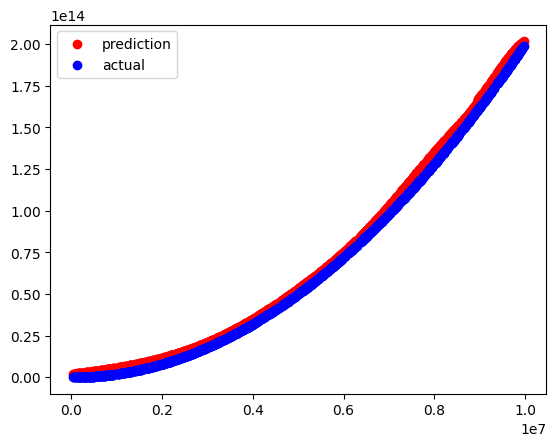

In [934]:
plt.scatter(X, np.array([model([x]).data for x in X_norm]) * np.std(Y) + np.mean(Y), c='r', label='prediction')
plt.scatter(X, Y, c='b', label='actual')
plt.legend()

In [597]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.children:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [760]:
l1 = Linear(1, 50)
l2 = Linear(50, 1, nonlinear=False)

model = Model([l1, l2])

In [765]:
avg_loss = 0
count = 0
for x, y in zip(X_norm, Y_norm):
    out = model([x])
    loss = (out - y) ** 2
    avg_loss += loss.data
    count += 1
print(f'avg_loss: {avg_loss/count}')

avg_loss: [0.0607194]


In [762]:
X = np.random.uniform(0, 10000000, 1000)
Y = 2*X**2

X_norm = (X - np.mean(X)) / np.std(X)
Y_norm = (Y - np.mean(Y)) / np.std(Y)

In [763]:
for _ in (t:=trange(10000)):
    ix = np.random.randint(0, X.shape[0], (1,))
    logits = model(X_norm[ix])

    loss = (logits - Y_norm[ix])**2

    model.zero_grad()

    loss.backward()

    loss.step()
    
    t.set_description(f'loss: {loss.data[0]:.4}')

loss: 0.2543:  10%|█         | 1044/10000 [00:06<00:51, 172.93it/s]   


KeyboardInterrupt: 

In [24]:
input_value = 60
normalized_input = (input_value - np.mean(X)) / np.std(X)

# Making a prediction
normalized_output = model([normalized_input])

# Denormalizing the output
denormalized_output = (normalized_output * np.std(Y)) + np.mean(Y)

denormalized_output

data: [376299.222715], grad: 0, op: +

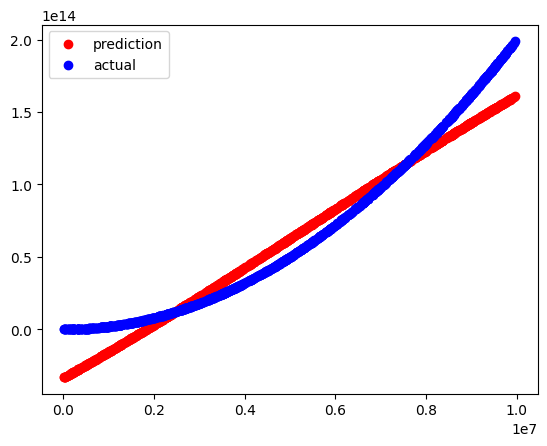

In [764]:
plt.scatter(X, np.array([model([x]).data for x in X_norm]) * np.std(Y) + np.mean(Y), c='r', label='prediction')
plt.scatter(X, Y, c='b', label='actual')
plt.legend()

In [13]:
words = open('words.txt', 'r').read().splitlines()
random.shuffle(words)
content_len = 1
feature_count = 10

chars = sorted(set('.'.join(words)))

itos = {i: c for i, c in enumerate(chars)}
stoi = {c: i for i, c in enumerate(chars)}

def build_dataset(words):
    X, Y = [], []
    context = [0] * content_len
    for word in words:
        word += '.'
        for c in word:
            X.append(context)
            Y.append(stoi[c])
            context = context[1:] + [stoi[c]]
    
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [14]:
Xtrain, Ytrain = build_dataset(words)

C = Embedding(27, feature_count)
l1 = Linear(content_len * feature_count, 75)
l2 = Linear(75, 27, nonlinear=False)

model = Model([C, l1, l2])

In [18]:
import queue
import threading
import time

q = queue.Queue()

for i in [3, 2,1]:
    def f():
        time.sleep(i)
        q.put(i)
    threading.Thread(target=f).start()

print(q.get())

1


In [15]:
for _ in (t:=trange(300)):
    ix = int(np.random.randint(0, Xtrain.shape[0], (1,)))

    out = model(Xtrain[ix])

    expected = Ytrain[ix]

    maxVal = max([num.data for num in out])

    exp = [(2**(num-maxVal)) for num in out]

    count = sum([num.data for num in exp])

    prob = [val/count for val in exp]

    loss = prob[int(Ytrain[ix])].log()*-1

    model.zero_grad()

    loss.backward()

    loss.step(lr=0.01)
    
    t.set_description(f'loss: {loss.data}')

loss: 3.272425614919388:  37%|███▋      | 110/300 [00:05<00:09, 19.33it/s] 


KeyboardInterrupt: 

In [16]:
avg_loss = 0
countt = 0
random.shuffle(words)
for word in words[:10]:
    for ch1, ch2 in zip(word, word[1:]):
        input = [stoi[ch1]]
        expected = stoi[ch2]
        out = model(input)

        maxVal = max([num.data for num in out])

        exp = [(2**(num-maxVal)) for num in out]

        count = sum([num.data for num in exp])

        prob = [val/count for val in exp]

        loss = prob[int(expected)].log()*-1

        avg_loss += loss.data
        countt += 1

print(f'loss: {avg_loss/countt}')

loss: 3.2857463631662767
